## 1. Import necessary library ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chemparse as cp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

## 2. Preprocessing ##

* Import data

In [2]:
raw_data = pd.read_csv('data/lithium-ion batteries.csv')

In [3]:
raw_data.head()

,Materials Id,Formula,Spacegroup,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
0,mp-849394,Li2MnSiO4,Pc,-2.699,0.006,3.462,16,2.993,178.513,True,monoclinic
1,mp-783909,Li2MnSiO4,P21/c,-2.696,0.008,2.879,32,2.926,365.272,True,monoclinic
2,mp-761311,Li4MnSi2O7,Cc,-2.775,0.012,3.653,28,2.761,301.775,True,monoclinic
3,mp-761598,Li4Mn2Si3O10,C2/c,-2.783,0.013,3.015,38,2.908,436.183,True,monoclinic
4,mp-767709,Li2Mn3Si3O10,C2/c,-2.747,0.016,2.578,36,3.334,421.286,True,monoclinic


* Strip and one-hot encode

In [4]:
data = raw_data.drop(["Materials Id","Spacegroup"], axis=1)

In [5]:
chrystal_sys_list = data["Crystal System"].unique()
for idx,sys in enumerate(chrystal_sys_list):
    print("Encode {} as {}".format(sys,idx))
    data["Crystal System"].replace(sys,idx,inplace=True)
data.head()

Encode monoclinic as 0
Encode orthorhombic as 1
Encode triclinic as 2


,Formula,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
0,Li2MnSiO4,-2.699,0.006,3.462,16,2.993,178.513,True,0
1,Li2MnSiO4,-2.696,0.008,2.879,32,2.926,365.272,True,0
2,Li4MnSi2O7,-2.775,0.012,3.653,28,2.761,301.775,True,0
3,Li4Mn2Si3O10,-2.783,0.013,3.015,38,2.908,436.183,True,0
4,Li2Mn3Si3O10,-2.747,0.016,2.578,36,3.334,421.286,True,0


In [6]:
nn = data["Formula"].apply(cp.parse_formula)
nn = pd.json_normalize(nn)
nn = nn.fillna(0)
nn.head()

,Li,Mn,Si,O,Fe,Co
0,2.0,1.0,1.0,4.0,0.0,0.0
1,2.0,1.0,1.0,4.0,0.0,0.0
2,4.0,1.0,2.0,7.0,0.0,0.0
3,4.0,2.0,3.0,10.0,0.0,0.0
4,2.0,3.0,3.0,10.0,0.0,0.0


In [7]:
data=data.join(nn)
data.head()

,Formula,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System,Li,Mn,Si,O,Fe,Co
0,Li2MnSiO4,-2.699,0.006,3.462,16,2.993,178.513,True,0,2.0,1.0,1.0,4.0,0.0,0.0
1,Li2MnSiO4,-2.696,0.008,2.879,32,2.926,365.272,True,0,2.0,1.0,1.0,4.0,0.0,0.0
2,Li4MnSi2O7,-2.775,0.012,3.653,28,2.761,301.775,True,0,4.0,1.0,2.0,7.0,0.0,0.0
3,Li4Mn2Si3O10,-2.783,0.013,3.015,38,2.908,436.183,True,0,4.0,2.0,3.0,10.0,0.0,0.0
4,Li2Mn3Si3O10,-2.747,0.016,2.578,36,3.334,421.286,True,0,2.0,3.0,3.0,10.0,0.0,0.0


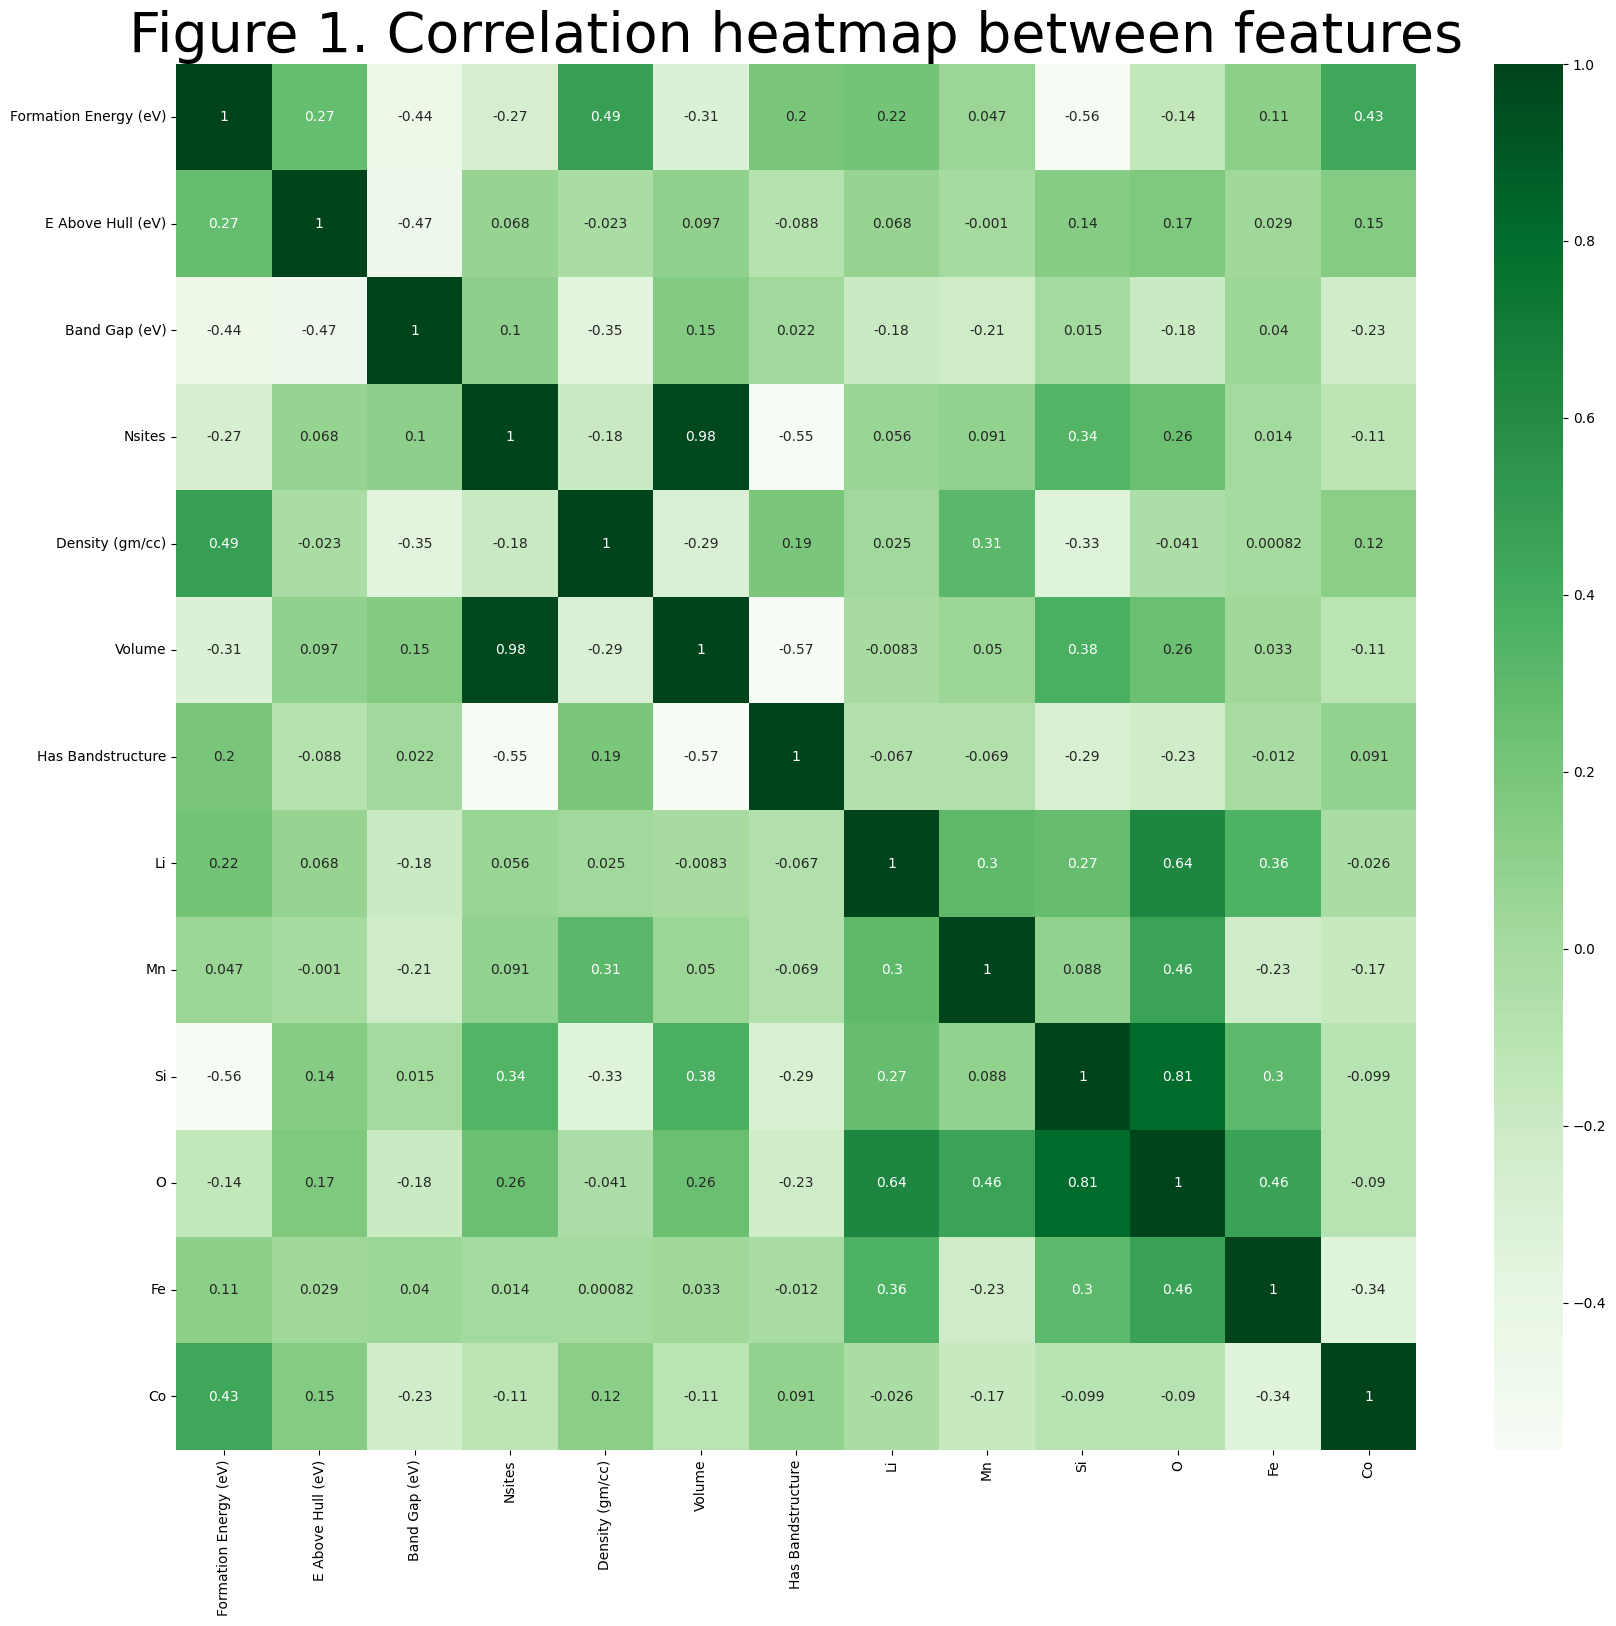

In [8]:
correlations = data.loc[:, ~data.columns.isin(['Formula','Crystal System'])].corr()
plt.figure(figsize=(20,18))
sns.heatmap(correlations, annot=True,cmap=plt.cm.Greens)
plt.title('Figure 1. Correlation heatmap between features',fontsize = 40)
plt.show()

Text(0.5, 1.0, 'Figure 2. Distribution of crystal systems')

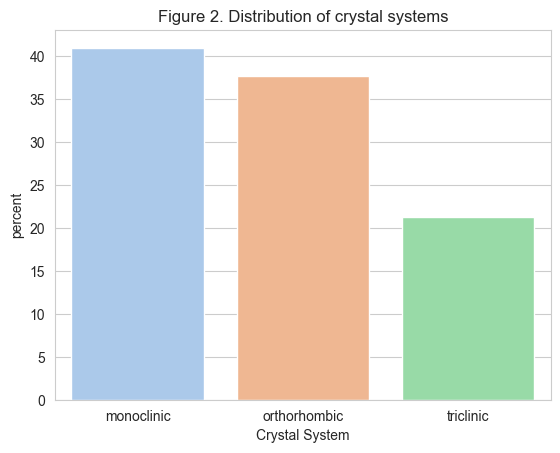

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='Crystal System', hue = "Crystal System", data=raw_data, palette="pastel", stat="percent")
plt.title("Figure 2. Distribution of crystal systems")

Text(0.5, 1.0, 'Figure 3. Distribution of bandstructure')

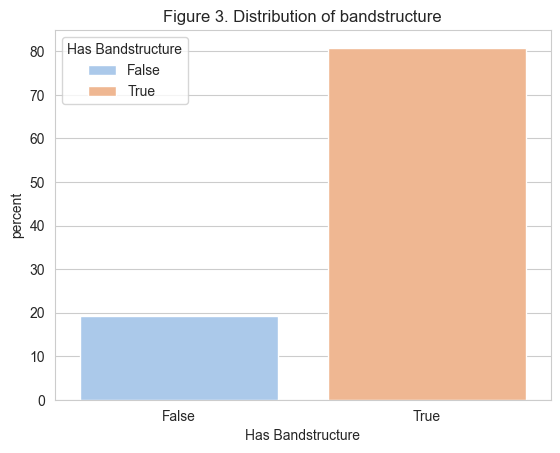

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='Has Bandstructure', hue = "Has Bandstructure", data=raw_data, palette="pastel", stat="percent")
plt.title("Figure 3. Distribution of bandstructure")

## 3. Gradient Boost ##

In [11]:
chem_formula = data['Formula']
chem_formula

0            Li2MnSiO4
1            Li2MnSiO4
2           Li4MnSi2O7
3         Li4Mn2Si3O10
4         Li2Mn3Si3O10
            ...       
334       Li6Co(SiO4)2
335       LiCo3(SiO4)2
336    Li5Co4(Si3O10)2
337           LiCoSiO4
338      Li3Co2(SiO4)2
Name: Formula, Length: 339, dtype: object

In [12]:
X = data.drop(["Crystal System","Formula"], axis=1)
X

,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Li,Mn,Si,O,Fe,Co
0,-2.699,0.006,3.462,16,2.993,178.513,True,2.0,1.0,1.0,4.0,0.0,0.0
1,-2.696,0.008,2.879,32,2.926,365.272,True,2.0,1.0,1.0,4.0,0.0,0.0
2,-2.775,0.012,3.653,28,2.761,301.775,True,4.0,1.0,2.0,7.0,0.0,0.0
3,-2.783,0.013,3.015,38,2.908,436.183,True,4.0,2.0,3.0,10.0,0.0,0.0
4,-2.747,0.016,2.578,36,3.334,421.286,True,2.0,3.0,3.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,-2.545,0.071,2.685,17,2.753,171.772,True,6.0,0.0,2.0,8.0,0.0,1.0
335,-2.250,0.076,0.005,42,3.318,552.402,True,1.0,0.0,2.0,8.0,0.0,3.0
336,-2.529,0.082,0.176,35,2.940,428.648,True,5.0,0.0,6.0,20.0,0.0,4.0
337,-2.348,0.087,1.333,14,2.451,214.044,True,1.0,0.0,1.0,4.0,0.0,1.0


In [13]:
y = data['Crystal System']
y

0      0
1      0
2      0
3      0
4      0
      ..
334    2
335    2
336    2
337    2
338    2
Name: Crystal System, Length: 339, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

* Find number of weak learners

In [119]:
performance = pd.DataFrame([],columns=["Estimator","Learning rate","depth","test score", "train score"])
max = 50
step = 1
start = 10
learn_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
tree_depths = [3,4,5,6,7]
for weak_learners in range(start,max,step):
    for rate in learn_rates:
        for depth in tree_depths:
            model = GradientBoostingClassifier(n_estimators=weak_learners,learning_rate=rate,max_depth=depth,random_state=12)
            # cv_results = cross_validate(model, X, y, cv = 5, scoring = "f1_macro", return_train_score = True)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            f_score_test   = f1_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
            # f_score_test = np.average(cv_results["test_score"])
            y_pred = model.predict(X_train)
            f_score_train   = f1_score(y_true=y_train, y_pred=y_pred, average='macro',zero_division=0)
            # f_score_train = np.average(cv_results["train_score"])
            # precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
            # recall    =    recall_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
            new_performance = [weak_learners, rate, depth, f_score_test, f_score_train]
            performance.loc[len(performance)] = new_performance
            # print("Precision: {}\nRecall: {}\nF1 Score: {}".format(precision,recall,f_score))


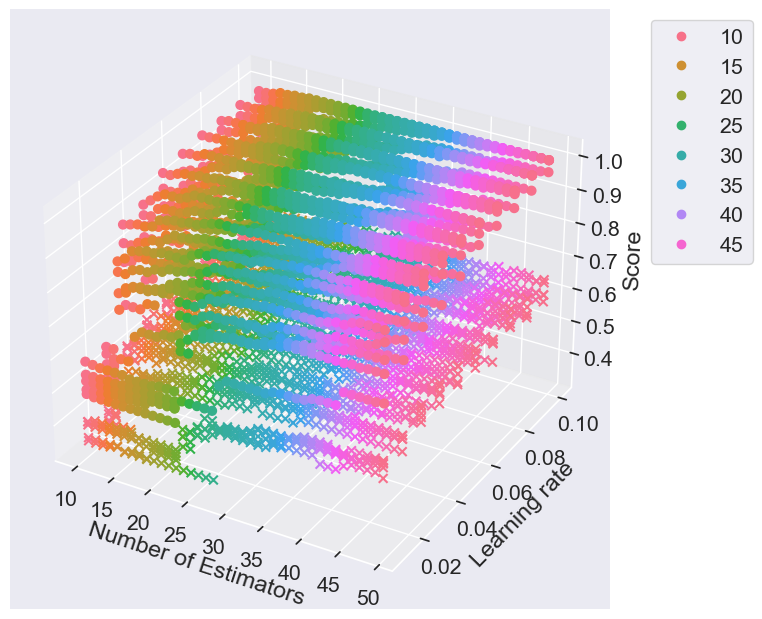

In [120]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
ax.scatter(performance["Estimator"], performance['Learning rate'],performance['test score'], s=40, c=performance["Estimator"], marker='x', cmap=cmap, alpha=1)
sc = ax.scatter(performance["Estimator"], performance['Learning rate'],performance['train score'], s=40, c=performance["Estimator"], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Learning rate')
ax.set_zlabel('Score')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

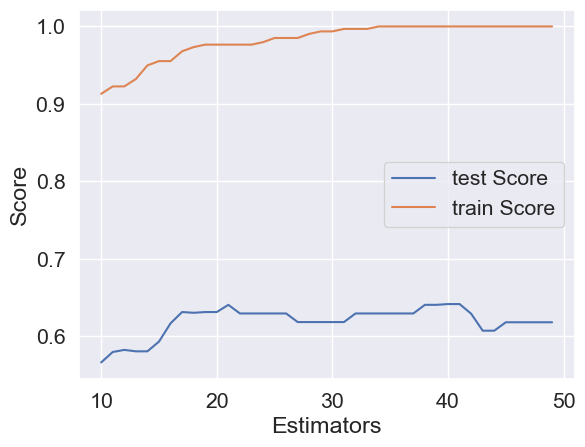

,Estimator,Learning rate,depth,test score,train score
578,21.0,0.06,6.0,0.640671,0.97652


In [147]:
performance_lr = (performance.loc[performance['Learning rate'] == 0.06]).loc[performance['depth'] == 6]
plt.plot(performance_lr["Estimator"], performance_lr['test score'], label = "test Score")
plt.plot(performance_lr["Estimator"], performance_lr['train score'], label = "train Score")
# plt.plot(range(100,3000,20), performance['Precision score'], label = "Precision Score")
# plt.plot(range(100,3000,20), performance['Recall score'], label = "Recall Score")
plt.legend()
plt.xlabel("Estimators")
plt.ylabel("Score")
plt.show()
performance_lr.loc[performance_lr['Estimator'] == 21]

In [139]:
model = GradientBoostingClassifier(n_estimators=21,learning_rate=0.06,max_depth=6, random_state=12)
cv_results = cross_validate(model, X, y, cv = 5, scoring = "f1_macro", return_train_score = True)
print(cv_results["test_score"])
np.average(cv_results["test_score"])

[0.75223012 0.73418803 0.63863441 0.67395264 0.52128077]


0.6640571943122626

In [143]:
optimal_estimator = 21
optimal_learn_rate = 0.06
optimal_depth = 6
model = GradientBoostingClassifier(n_estimators=optimal_estimator,learning_rate=optimal_learn_rate,max_depth=optimal_depth)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f_score   =        f1_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
recall    =    recall_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
print("Precision: {}\nRecall: {}\nF1 Score: {}".format(precision,recall,f_score))


Precision: 0.6422840192806822
Recall: 0.6462850729517396
F1 Score: 0.640671156800189


Has Bandstructure: 0.0011676193752649924
Mn: 0.003878982322124398
Co: 0.0068202646181567345
Si: 0.011333041231524475
Fe: 0.02189439473940841
Li: 0.055585163210228945
Formation Energy (eV): 0.05661043107386426
E Above Hull (eV): 0.0701231210869973
Band Gap (eV): 0.10822756537822521
Nsites: 0.11011946081850686
Density (gm/cc): 0.11067509645691709
O: 0.18605131573532044
Volume: 0.2575135439534609


Text(0, 0.5, 'Features')

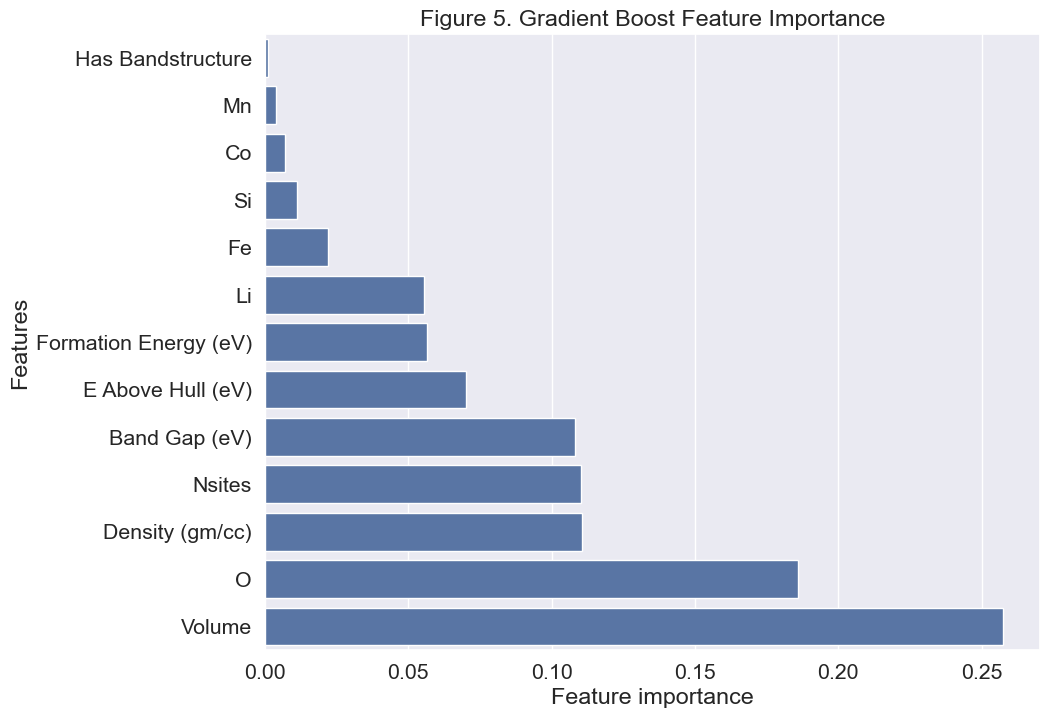

In [144]:
# find feature importance
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
features_names = X.columns.to_numpy()
feature_importance_name = np.array(features_names)[sorted_idx]
feature_importance_df = pd.DataFrame([],columns=["Feature", "Importance"])
for idx, item in enumerate(feature_importance_name):
    print("{}: {}".format(item,feature_importance[sorted_idx[idx]]))
    feature_importance_df.loc[len(feature_importance_df)] = [item, feature_importance[sorted_idx[idx]].copy()]

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'])
#Add chart labels
plt.title('Figure 5. Gradient Boost Feature Importance')
plt.xlabel('Feature importance')
plt.ylabel('Features')


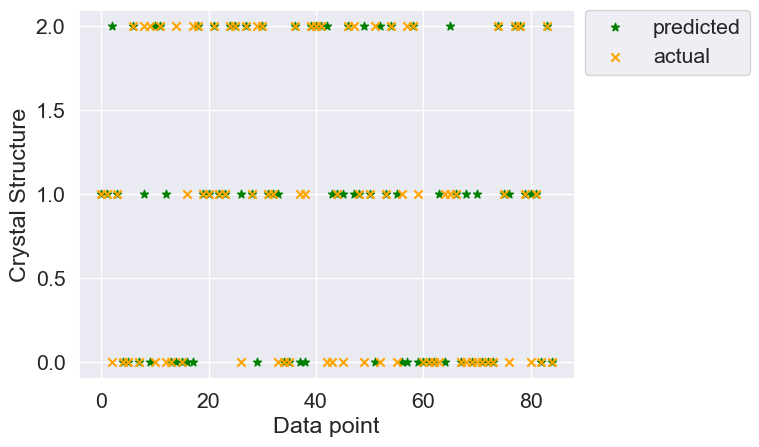

In [145]:
# graph the model's prediction vs correct result
plt.scatter(x=range(0,len(y_pred)), y=y_pred, marker='*', c='green', label='predicted')
plt.scatter(x=range(0,len(y_test)), y=y_test, marker='x', c='orange', label='actual')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Data point")
plt.ylabel("Crystal Structure")
plt.show()

Text(0.5, 1.0, 'Figure 4. Confusion matrix of the test dataset')

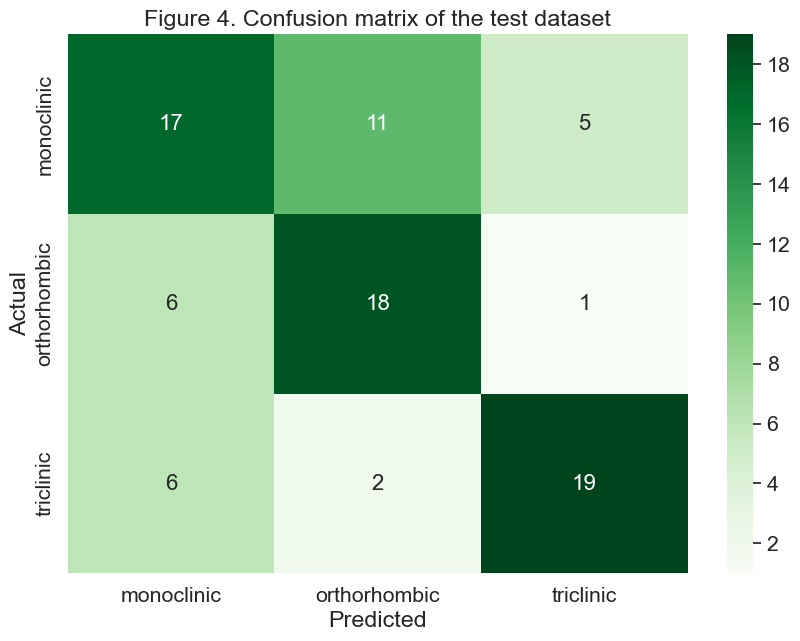

In [146]:
data_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data_matrix, columns=np.unique(chrystal_sys_list), index = np.unique(chrystal_sys_list))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Greens", annot=True,annot_kws={"size": 16})
plt.title("Figure 4. Confusion matrix of the test dataset")

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
cv_results = cross_validate(rf_model, X, y, cv = 10,
                            scoring='f1_macro',
                            return_train_score=True)
print(cv_results["test_score"])
print(np.average(cv_results["test_score"]))

print(cv_results["train_score"])
np.average(cv_results["train_score"])

[0.81443495 0.71965812 0.53968254 0.66312997 0.77954145 0.67010245
 0.61083744 0.59313526 0.7429694  0.69444444]
0.6827936014432685
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


1.0